In [116]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import log10, sqrt

In [117]:
# read cameraman and NIT Logo images from Images folder
NITLogo = cv2.imread("Images/Logo_NIT_Binary.png", cv2.IMREAD_GRAYSCALE)
cameraman = cv2.imread("Images/camera_256.jpg", cv2.IMREAD_GRAYSCALE)


In [118]:
# converting Nit logo to binary form
(thresh, NITLogo) = cv2.threshold(NITLogo, 128, 1, cv2.THRESH_BINARY)

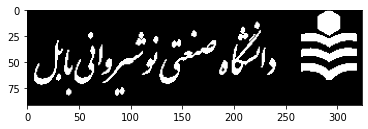

In [119]:
# demonstarting binary Nit logo
plt.imshow(cv2.bitwise_not(NITLogo), cmap="Greys")
plt.show()

In [120]:
# resize the NIT Logo with bilinear method
NITLogo = cv2.resize(
    NITLogo, (int(NITLogo.shape[1]*0.5), int(NITLogo.shape[0]*0.5)), interpolation=cv2.INTER_LINEAR)

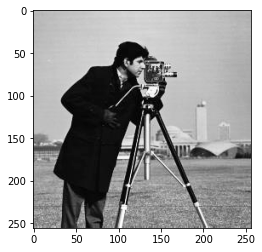

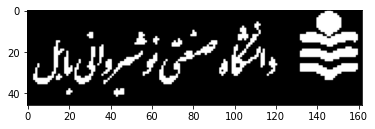

In [121]:
# demonstarting the cameraman image and binary shrinked Nit logo
plt.imshow(cv2.bitwise_not(cameraman), cmap="Greys")
plt.show()

plt.imshow(cv2.bitwise_not(NITLogo), cmap="Greys")
plt.show()

In [122]:
# location of watermark (center of picture)
def get_watermark_position(image, logo):
    hl, wl = logo.shape
    hi, wi = image.shape
    # calculating coordinates of center 
    center_y = int(hi/2)
    center_x = int(wi/2)

    # calculating from top, bottom, right and left
    top_y = center_y - int(hl/2)
    left_x = center_x - int(wl/2)
    bottom_y = top_y + hl
    right_x = left_x + wl

    return top_y, left_x, bottom_y, right_x

In [123]:
# calling function that find position of watermark
top_y, left_x, bottom_y, right_x = get_watermark_position(cameraman, NITLogo)


In [124]:
# implementing lsb function
def lsb_watermarked_image(NITLogo, cameraman, top_y, left_x, bottom_y, right_x):
   watermarked_image = cameraman.copy()
   # adding watermark to the cameraman image
   destination = watermarked_image[top_y:bottom_y, left_x:right_x]
    
   for i in range(NITLogo.shape[0]):
      for j in range(NITLogo.shape[1]):
            # convert the pixel in cameraman to binary
            h = destination[i][j]
            b_p = f'{destination[i][j]:08b}'

            # get the lsb pixel
            lsb_p = int(b_p[7])
            l_p = int(NITLogo[i][j])
            # add binary pixel of the NITLogo to lsb of the image
            b = 0
            if (False):
               b = 0
            else:
               # or
               b = (lsb_p | l_p)

            b_p = b_p[:7] + str(b)
            # convert the cameraman's pixel binary value back to decimal
            destination[i][j] = int(b_p, 2)

   result = destination + NITLogo

   watermarked_image[top_y:bottom_y, left_x:right_x] = result

   return watermarked_image

In [125]:
# implementing between pixel function
def bp_watermarked_image(NITLogo, cameraman, top_y, left_x, bottom_y, right_x):
   watermarked_image = cameraman.copy()
   destination = watermarked_image[top_y:bottom_y, left_x:right_x]
   result = cv2.addWeighted(destination, 1, NITLogo, 1, 0)

   watermarked_image[top_y:bottom_y, left_x:right_x] = result

   return watermarked_image

In [126]:
# watermarked image lsb method 
watermarked_image = lsb_watermarked_image(NITLogo, cameraman, top_y, left_x, bottom_y, right_x)


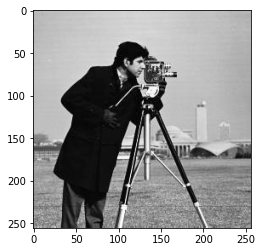

In [127]:
# demonstarting the watermarked image
plt.imshow(cv2.bitwise_not(watermarked_image), cmap="Greys")
plt.show()

In [128]:
# watermarked image bp method 
bp_watermarked_image = bp_watermarked_image(NITLogo, cameraman, top_y, left_x, bottom_y, right_x)

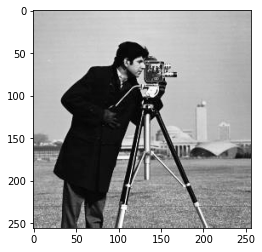

In [129]:
plt.imshow(cv2.bitwise_not(bp_watermarked_image), cmap="Greys")
plt.show()

In [130]:
# MSE for evaluation
def MSE(original, conveted):
    mse = np.mean((original - conveted) ** 2)
    return mse

In [131]:
# PSNR for evaluation
def PSNR(original, conveted):
    # at first we calculate MSE if it was equal to 0 it means there is no noise and then we return 100
    mse = MSE(original, conveted)
    if(mse == 0):
        return 100
    m_p = 255.0
    psnr = 20 * log10(m_p / sqrt(mse))
    return psnr

In [132]:
# calling MSE for our watermarked image
mse = MSE(cameraman, watermarked_image)

In [133]:
# showing the MSE
print(mse)

0.04095458984375


In [134]:
# calling PSNR for our watermarked image
psnr = PSNR(cameraman, watermarked_image)

In [135]:
# showing the PSNR
print(psnr)

62.00777779994655


In [136]:
bp_mse = MSE(cameraman, bp_watermarked_image)

In [137]:
print(bp_mse)

0.016326904296875


In [138]:
bp_psnr = PSNR(cameraman, bp_watermarked_image)

In [139]:
print(bp_psnr)

66.001765138064


In [140]:
def add_gaussian_noise(cameraman, mean, variance):
    s_d = np.sqrt(variance)
    noise = np.random.normal(mean, s_d, cameraman.shape)

    cameraman_with_noise = (cameraman + noise)

    return cameraman_with_noise

In [141]:
lsb_variance02 = add_gaussian_noise(
    watermarked_image, mean=0, variance=0.02)
lsb_variance15 = add_gaussian_noise(
    watermarked_image, mean=0, variance=0.15)
lsb_variance50 = add_gaussian_noise(
    watermarked_image, mean=0, variance=0.5)
lsb_variance200 = add_gaussian_noise(
    watermarked_image, mean=0, variance=2)

In [142]:
def decode(original_cameraman, converted_cameraman, top_y, left_x, bottom_y, right_x):
    res = np.abs(np.subtract(original_cameraman, converted_cameraman))
    logo = res[top_y:bottom_y, left_x:right_x]
    return logo

In [143]:
noised_lsb_variance02 = decode(cameraman, lsb_variance02, top_y, left_x, bottom_y, right_x)
noised_lsb_variance15 = decode(cameraman, lsb_variance15, top_y, left_x, bottom_y, right_x)
noised_lsb_variance50 = decode(cameraman, lsb_variance50, top_y, left_x, bottom_y, right_x)
noised_lsb_variance200 = decode(cameraman, lsb_variance200, top_y, left_x, bottom_y, right_x)

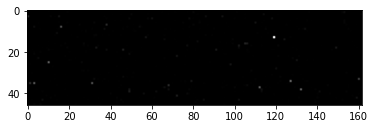

In [144]:
plt.imshow(cv2.bitwise_not(noised_lsb_variance02), cmap="Greys")
plt.show()

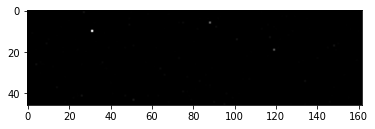

In [145]:
plt.imshow(cv2.bitwise_not(noised_lsb_variance15), cmap="Greys")
plt.show()

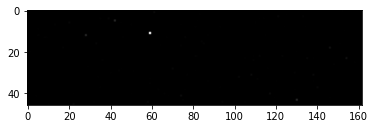

In [146]:
plt.imshow(cv2.bitwise_not(noised_lsb_variance50), cmap="Greys")
plt.show()

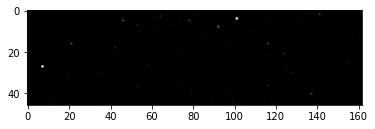

In [147]:
plt.imshow(cv2.bitwise_not(noised_lsb_variance200), cmap="Greys")
plt.show()

In [148]:

bp_variance02 = add_gaussian_noise(
    bp_watermarked_image, mean=0, variance=0.02)
bp_variance15 = add_gaussian_noise(
    bp_watermarked_image, mean=0, variance=0.15)
bp_variance50 = add_gaussian_noise(
    bp_watermarked_image, mean=0, variance=0.5)
bp_variance200 = add_gaussian_noise(
    bp_watermarked_image, mean=0, variance=2)

In [149]:
noised_bp_variance02 = decode(cameraman, bp_variance02, top_y, left_x, bottom_y, right_x)
noised_bp_variance15 = decode(cameraman, bp_variance15, top_y, left_x, bottom_y, right_x)
noised_bp_variance50 = decode(cameraman, bp_variance50, top_y, left_x, bottom_y, right_x)
noised_bp_variance200 = decode(cameraman, bp_variance200, top_y, left_x, bottom_y, right_x)

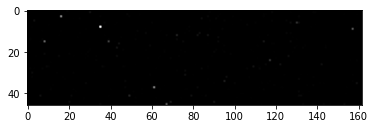

In [150]:
plt.imshow(cv2.bitwise_not(noised_bp_variance02), cmap="Greys")
plt.show()

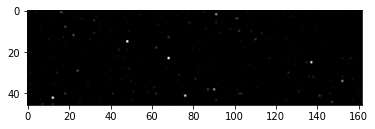

In [151]:
plt.imshow(cv2.bitwise_not(noised_bp_variance15), cmap="Greys")
plt.show()

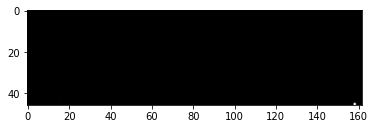

In [152]:
plt.imshow(cv2.bitwise_not(noised_bp_variance50), cmap="Greys")
plt.show()

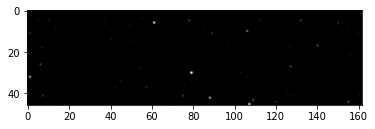

In [153]:
plt.imshow(cv2.bitwise_not(noised_bp_variance200), cmap="Greys")
plt.show()